In [1]:
import numpy as np
import pandas as pd
import torch
torch.set_default_tensor_type(torch.FloatTensor) 
import copy

from rct_data_generator import *
from outcome_models import *
from plotting_functions import *
from mcmc_bayes_update import *
from eig_comp_utils import *
from research_exp_utils import *
from rct_data_generator import generate_host_and_mirror


/Users/lucile/causal_info_gain/pjake/lib/python3.9/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


### 1. Simulating the data

In [2]:
rng = np.random.RandomState(42)

n_rct_before_split = 10**6
n_host = 200
sigma_prior = 1
sigma_rand_error = 1

power_x, power_x_t = 1, 1
causal_param_first_index = 4
outcome_function = lambda X, T, eps: 1 + 1 * X[:,0] - 1 * X[:,1] + 1 * X[:,2] + 4 * T + 2* X[:,0]*T + 24* X[:,1]*T + 0* X[:,2]*T + eps 
std_true_y = 1 # Standard deviation for the true Y

X0 = np.random.beta(12, 3, size= n_rct_before_split)
X1 = np.random.normal(loc=4, scale=1, size=n_rct_before_split)
X2 = np.random.beta(1, 7, size=n_rct_before_split)
x_distributions= {0: X0, 1: X1, 2:X2}
d = 1 + len(x_distributions)*(power_x) + 1 + len(x_distributions)*(power_x_t)


p_assigned_to_host = lambda X_0, X_1, T, eps: sigmoid(1 + 2*X_0 - X_1 + 3*T + eps)
p_assigned_to_cand2 = lambda X_0, X_1, T, eps: sigmoid(1 + 2*X_0 - X_1 + 3*T + eps) #can't take X_2, harcoded still

Simulation parameters

In [3]:
# Prior parameters for Bayesian update on host
prior_mean = torch.zeros(d)
beta_0, sigma_0_sq, inv_cov_0 = prior_mean, sigma_rand_error,torch.eye(d)
prior_hyperparameters = {'beta_0': beta_0, 'sigma_0_sq': sigma_0_sq,"inv_cov_0":inv_cov_0}

# Hyperparameters for Bayesian update on host
warmup_steps = 50
max_tree_depth = 5

# Number of samples used to estimate outer expectation
n_samples_for_expectation = 50
m_samples_for_expectation = 1000


# Incorporating sqrt constraint into MCMC samples
n_mc = (n_samples_for_expectation * (m_samples_for_expectation+1)) 

In [4]:
n_both_candidates_list = [200, 500, 1000]
proportion = 1 #n_cand2 = prorportion * n_both_candidates_list
std_true_y = 1


data_parameters = {'n_both_candidates_list': n_both_candidates_list, 'proportion':proportion, 'n_rct_before_split':n_rct_before_split, \
                   'x_distributions':x_distributions, 'p_assigned_to_cand2':p_assigned_to_cand2, 'n_host':n_host, 'power_x':power_x, \
                    'power_x_t':power_x_t, 'outcome_function':outcome_function, 'std_true_y':std_true_y, 'causal_param_first_index':causal_param_first_index}

### 2. EIG closed form for varying sample sizes

In [24]:
n_seeds=10
plot_additional = True

text_l1 ='p_assigned_to_host=p_assigned_to_cand2, 0.75 of treated in host, '
text_l2 = 'n_host = 200, sigma_prior = sigma_rand_error= 1, sigma_rand_error = 1,'
text_l3 = 'outcome_function = 1 + 1 * X[:,0] - 1 * X[:,1] + 1 * X[:,2] + 1 * T + 2* X[:,0]*T + 2* X[:,1]*T +2* X[:,2]*T +eps'

In [25]:
if not plot_additional:
    dict_additional_plots_obs = dict_additional_plots_caus = {'Exact complementary':0, 'Exact twin': 0, 'Exact twin treated': 0, 'Exact twin untreated': 0}

else:
    dict_additional_plots_obs, dict_additional_plots_caus = eig_closed_form_exact_datasets(data_parameters, sigma_rand_error, prior_hyperparameters, n_mc)

EIG_obs_closed_form_across_seeds, EIG_caus_closed_form_across_seeds = [], []

for i in range (n_seeds):
    EIG_obs_closed_form, EIG_caus_closed_form = eig_closed_form_varying_sample_size(data_parameters, sigma_rand_error, prior_hyperparameters, n_mc)
    if len(EIG_obs_closed_form_across_seeds)==0:
        EIG_obs_closed_form_across_seeds= EIG_obs_closed_form
        EIG_caus_closed_form_across_seeds = EIG_caus_closed_form
    else:
        EIG_obs_closed_form_across_seeds = np.vstack((EIG_obs_closed_form_across_seeds, EIG_obs_closed_form))
        EIG_caus_closed_form_across_seeds = np.vstack((EIG_caus_closed_form_across_seeds, EIG_caus_closed_form))
    

300
800


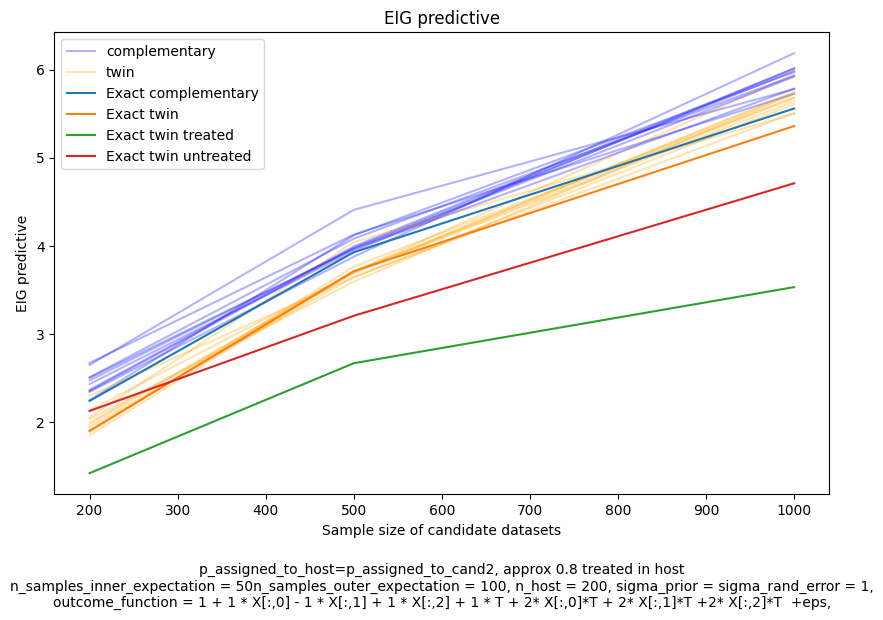

In [35]:
path_obs_closed_form = '/Users/lucile/causal_info_gain/plots/eig_obs_closed_form'
#path_obs_closed_form = 0
alpha = 0.3

plot_array(dict_additional_plots_obs, n_both_candidates_list, EIG_obs_closed_form_across_seeds, axis_names= ['Sample size of candidate datasets', 'EIG predictive'], names=['complementary','twin'],
           text= text_l1+ '\n' + text_l2+ '\n' + text_l3, title= 'EIG predictive', save=path_obs_closed_form, alpha = alpha)

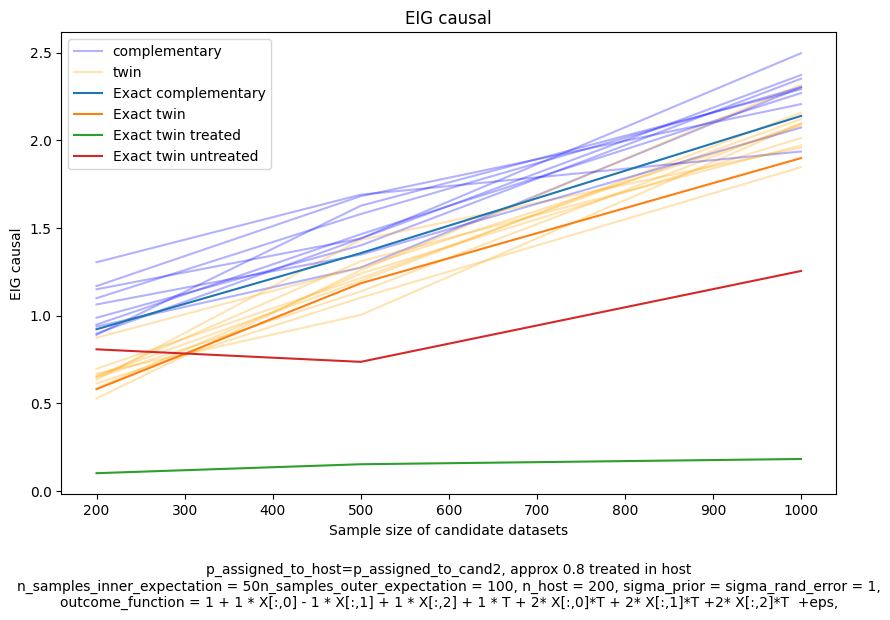

In [34]:
path_caus_closed_form = '/Users/lucile/causal_info_gain/plots/eig_caus_closed_form'
#path_caus_closed_form = 0
alpha = 0.3

plot_array(dict_additional_plots_caus, n_both_candidates_list, EIG_caus_closed_form_across_seeds, axis_names= ['Sample size of candidate datasets', 'EIG causal'], names=['complementary','twin'],
           text= text_l1+ '\n' + text_l2+ '\n' + text_l3, title= 'EIG causal', save=path_caus_closed_form, alpha = alpha)

### 2. EIG from samples for varying sample sizes

In [9]:
n_samples_outer_expectation = 100
n_samples_inner_expectation = 50
n_causal_outer_exp = 100
n_causal_inner_exp = 50

sampling_parameters = {'n_samples_inner_expectation':n_samples_inner_expectation, 'n_samples_outer_expectation':n_samples_outer_expectation, \
                       'n_causal_inner_exp':n_causal_inner_exp, 'n_causal_outer_exp':n_causal_outer_exp}

In [10]:
n_seeds = 10
EIG_obs_samples_across_seeds, EIG_caus_samples_across_seeds = [], []

for i in range (n_seeds):
    EIG_obs_samples, EIG_caus_samples = eig_from_samples_varying_sample_size(data_parameters, sigma_rand_error, prior_hyperparameters, sampling_parameters)
    if len(EIG_obs_samples_across_seeds)==0:
        EIG_obs_samples_across_seeds= EIG_obs_samples
        EIG_caus_samples_across_seeds = EIG_caus_samples
    else:
        EIG_obs_samples_across_seeds = np.vstack((EIG_obs_samples_across_seeds, EIG_obs_samples))
        EIG_caus_samples_across_seeds = np.vstack((EIG_caus_samples_across_seeds, EIG_caus_samples))

For a sample size in candidates of 200
Percentage of treated in host: 81.5%
Percentage of treated in mirror: 21.5%
Percentage of treated in cand2: 73.0%
For a sample size in candidates of 500
Percentage of treated in host: 72.5%
Percentage of treated in mirror: 26.4%
Percentage of treated in cand2: 71.2%
For a sample size in candidates of 1000
Percentage of treated in host: 77.5%
Percentage of treated in mirror: 24.0%
Percentage of treated in cand2: 73.7%
For a sample size in candidates of 200
Percentage of treated in host: 76.5%
Percentage of treated in mirror: 22.0%
Percentage of treated in cand2: 77.5%
For a sample size in candidates of 500
Percentage of treated in host: 71.5%
Percentage of treated in mirror: 21.6%
Percentage of treated in cand2: 73.0%
For a sample size in candidates of 1000
Percentage of treated in host: 75.5%
Percentage of treated in mirror: 24.1%
Percentage of treated in cand2: 77.8%
For a sample size in candidates of 200
Percentage of treated in host: 71.3567839

In [28]:
text_l1 ='p_assigned_to_host=p_assigned_to_cand2, approx 0.8 treated in host'
text_l2 = 'n_samples_inner_expectation = '+str(n_samples_inner_expectation)+ 'n_samples_outer_expectation = '+str(n_samples_outer_expectation)+', n_host = 200, sigma_prior = sigma_rand_error = 1,'
text_l3 = 'outcome_function = 1 + 1 * X[:,0] - 1 * X[:,1] + 1 * X[:,2] + 1 * T + 2* X[:,0]*T + 2* X[:,1]*T +2* X[:,2]*T  +eps,'
text_l4 = 'n_host = 200, sigma_prior = sigma_rand_error = 1, n_causal_inner_exp = '+str(n_causal_inner_exp) 


plot_additional = 0

In [12]:
plot_additional = True
if not plot_additional:
    dict_additional_plots_obs = dict_additional_plots_caus = {'Exact complementary':0, 'Exact twin': 0, 'Exact twin treated': 0, 'Exact twin untreated': 0}

else:
    dict_additional_plots_obs, dict_additional_plots_caus = eig_closed_form_exact_datasets(data_parameters, sigma_rand_error, prior_hyperparameters, n_mc)

17
300
800


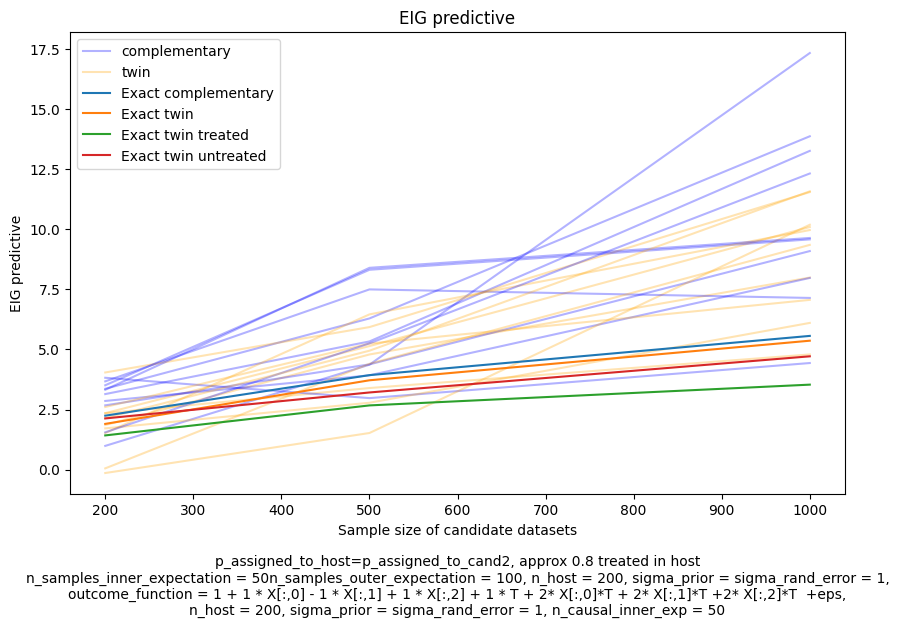

In [33]:
path_obs_samples = '/Users/lucile/causal_info_gain/plots/eig_obs_samples'
# path_obs_samples = 0
alpha = 0.3

plot_array(dict_additional_plots_obs, n_both_candidates_list, EIG_obs_samples_across_seeds, axis_names= ['Sample size of candidate datasets', 'EIG predictive'], names=['complementary','twin'],
           text= text_l1+ '\n' + text_l2+ '\n' + text_l3+ '\n' + text_l4, title= 'EIG predictive', save=path_obs_samples, alpha=alpha)

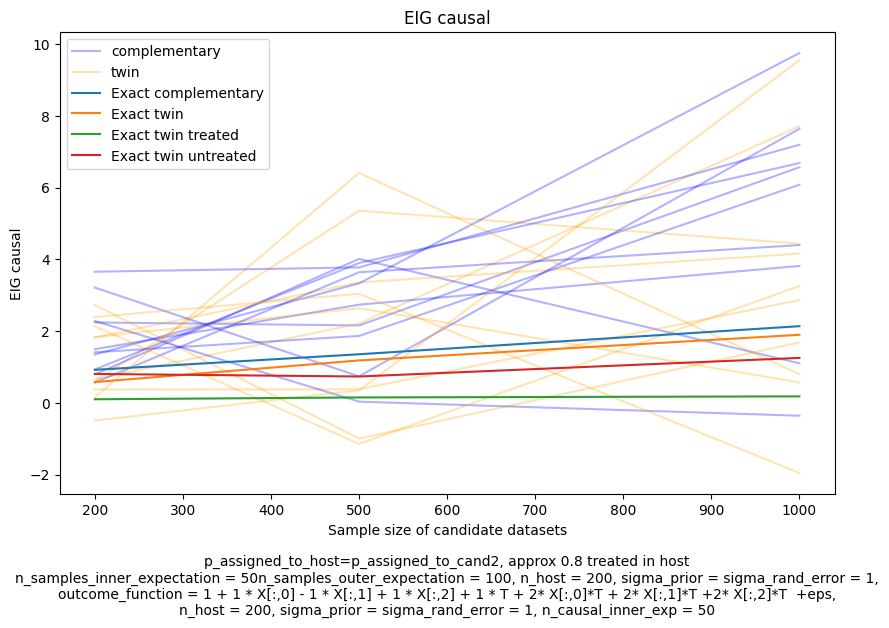

In [32]:
path_caus_samples = '/Users/lucile/causal_info_gain/plots/eig_caus_samples'
# path_caus_samples = 0
alpha = 0.3

plot_array(dict_additional_plots_caus, n_both_candidates_list, EIG_caus_samples_across_seeds, axis_names= ['Sample size of candidate datasets', 'EIG causal'], names=['complementary','twin'],
           text= text_l1+ '\n' + text_l2+ '\n' + text_l3+ '\n' + text_l4, title= 'EIG causal', save=path_caus_samples, alpha=alpha)

## 2. Extreme examples

In [15]:
# n_host_sample = 500 
# sigma_error = 1 

# X_host = (torch.randn((n_host_sample,d)) @ A ) 
# T_host = torch.bernoulli(torch.sigmoid(X_host@ T_allocation_host))
# X_host_times_T = (T_host.unsqueeze(dim=0).T * X_host)
# X_host = torch.concat([X_host,X_host_times_T],dim=1)

# Y_host = X_host @ mu
# Y_host = (1/Y_host.norm()) * Y_host + sigma_error * torch.randn_like(Y_host)

In [16]:
# prior_mean = torch.zeros(2 * d)
# beta_0, sigma_0_sq,inv_cov_0 = prior_mean, sigma_error,torch.eye(2*d)
# prior_hyperparameters = {'beta_0': beta_0, 'sigma_0_sq': sigma_0_sq,"inv_cov_0":inv_cov_0}
# bayesian_regression = BayesianLinearRegression(prior_hyperparameters)

In [17]:
# bayesian_regression.fit(X_host,Y_host)